<a href="https://colab.research.google.com/github/itsyashkhurana/Big-Data-Analystics/blob/main/10_Multivariate_Data_Analysis_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from factor_analyzer import FactorAnalyzer
from statsmodels.formula.api import ols
import statsmodels.api as sm

# 1. Load the Dataset
def load_data(url=None, filepath=None):
    """
    Loads the dataset from a URL or local file.  One of url or filepath must be provided.

    Args:
        url (str, optional): URL of the dataset. Defaults to None.
        filepath (str, optional): Local file path of the dataset. Defaults to None.

    Returns:
        pandas.DataFrame: The loaded dataset, or None on error.
    """
    if url:
        try:
            df = pd.read_csv(url)
            print(f"Data successfully loaded from: {url}")
            return df
        except Exception as e:
            print(f"Error loading data from URL: {e}")
            return None
    elif filepath:
        try:
            df = pd.read_csv(filepath)
            print(f"Data successfully loaded from: {filepath}")
            return df
        except Exception as e:
            print(f"Error loading data from file: {e}")
            return None
    else:
        print("Error: Either url or filepath must be provided.")
        return None

# 2. Explore the Data
def explore_data(df):
    """
    Explores the dataset by displaying the first few rows, data information,
    descriptive statistics, and checking for missing values.

    Args:
        df (pandas.DataFrame): The input dataset.
    """
    print("\nFirst 5 rows of the dataset:")
    print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

    print("\nData information (columns and types):")
    df.info()

    print("\nDescriptive statistics:")
    print(df.describe().to_markdown(numalign="left", stralign="left"))

    print("\nMissing values per column:")
    print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

# 3. Visualize the Data
def visualize_data(df, numerical_cols, categorical_cols):
    """
    Visualizes the data using histograms for numerical columns,
    count plots for categorical columns, and a heatmap for correlations.

    Args:
        df (pandas.DataFrame): The input dataset.
        numerical_cols (list): List of numerical column names.
        categorical_cols (list): List of categorical column names.
    """
    # Histograms for numerical columns
    if numerical_cols:
        df[numerical_cols].hist(figsize=(15, 10))
        plt.suptitle("Histograms of Numerical Variables", fontsize=16)
        plt.show()

    # Count plots for categorical columns
    if categorical_cols:
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(categorical_cols):
            plt.subplot(len(categorical_cols), 1, i+1)
            sns.countplot(x=col, data=df)
            plt.title(f"Count Plot of {col}")
        plt.tight_layout()
        plt.show()

    # Correlation heatmap for numerical columns
    if numerical_cols:
        corr_matrix = df[numerical_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title("Correlation Heatmap")
        plt.show()

# 4. Correlation Analysis
def correlation_analysis(df, numerical_cols, target_col=None):
    """
    Performs correlation analysis (Pearson, Spearman, Kendall) on numerical columns,
    optionally with respect to a target column.

    Args:
        df (pandas.DataFrame): The input dataset.
        numerical_cols (list): List of numerical column names.
        target_col (str, optional): Name of the target column for correlation with other numericals. Defaults to None.
    """
    if not numerical_cols:
        print("No numerical columns to perform correlation analysis.")
        return

    if target_col and target_col not in df.columns:
        print(f"Target column '{target_col}' not found in DataFrame.")
        return

    if target_col:
        print(f"\nCorrelation with target variable '{target_col}':")
        target_correlations = {}
        for col in numerical_cols:
            if col != target_col:
                pearson_corr, _ = pearsonr(df[col], df[target_col])
                spearman_corr, _ = spearmanr(df[col], df[target_col])
                kendall_corr, _ = kendalltau(df[col], df[target_col])
                target_correlations[col] = {
                    'Pearson': pearson_corr,
                    'Spearman': spearman_corr,
                    'Kendall': kendall_corr
                }
                print(f"\nCorrelations for {col} and {target_col}:")
                print(f"  Pearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f}, Kendall: {kendall_corr:.3f}")

        # Rank variables by correlation (absolute value)
        ranked_cols = sorted(target_correlations.items(),
                               key=lambda item: abs(item[1]['Pearson']), reverse=True)  # Use Pearson for ranking
        print("\nRanked variables by absolute Pearson correlation with target variable:")
        for col, corr_values in ranked_cols:
            print(f"{col}: Pearson={corr_values['Pearson']:.3f}, Spearman={corr_values['Spearman']:.3f}, Kendall={corr_values['Kendall']:.3f}")

    else: #If no target column
        print("\nPairwise correlations between numerical variables:")
        for i in range(len(numerical_cols)):
            for j in range(i + 1, len(numerical_cols)):
                col1 = numerical_cols[i]
                col2 = numerical_cols[j]
                pearson_corr, _ = pearsonr(df[col1], df[col2])
                spearman_corr, _ = spearmanr(df[col1], df[col2])
                kendall_corr, _ = kendalltau(df[col1], df[col2])
                print(f"\nCorrelations for {col1} and {col2}:")
                print(f"  Pearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f}, Kendall: {kendall_corr:.3f}")

# 5. Data Transformation
def transform_data(df, numerical_cols):
    """
    Transforms the data by scaling numerical columns using StandardScaler.

    Args:
        df (pandas.DataFrame): The input dataset.
        numerical_cols (list): List of numerical column names.

    Returns:
        pandas.DataFrame: The transformed dataset.
    """
    if not numerical_cols:
        print("No numerical columns to transform.")
        return df.  # Return original df to avoid errors later

    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    print("\nData scaled using StandardScaler.")
    return df

# 6. Dimensionality Reduction (PCA)
def perform_pca(df, numerical_cols, n_components=None):
    """
    Performs Principal Component Analysis (PCA) on the numerical columns.

    Args:
        df (pandas.DataFrame): The input dataset.
        numerical_cols (list): List of numerical column names.
        n_components (int, optional): Number of principal components. Defaults to None (all components).

    Returns:
        pandas.DataFrame: The PCA results.
    """
    if not numerical_cols:
        print("No numerical columns to perform PCA.")
        return None

    if n_components is None:
        n_components = len(numerical_cols)  # Use all if not specified.

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(df[numerical_cols])

    # Create a DataFrame for the principal components
    pc_df = pd.DataFrame(data=principal_components,
                           columns=[f'PC{i+1}' for i in range(n_components)])

    print("\nPCA results:")
    print(pc_df.head().to_markdown(index=False, numalign="left", stralign="left"))

    print("\nExplained variance ratio:")
    print(pca.explained_variance_ratio_)

    return pc_df

# 7. Feature Selection
def feature_selection(df, numerical_cols, target_col, k=5):
    """
    Performs feature selection using SelectKBest with f_regression and mutual_info_regression.

    Args:
        df (pandas.DataFrame): The input dataset.
        numerical_cols (list): List of numerical column names.
        target_col (str): Name of the target column.
        k (int, optional): Number of top features to select. Defaults to 5.
    """
    if not numerical_cols:
        print("No numerical columns to perform feature selection.")
        return

    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found in DataFrame.")
        return

    X = df[numerical_cols].copy() # Create a copy to avoid modifying the original DataFrame
    y = df[target_col].copy()     # Create a copy to avoid modifying the original DataFrame

    if k > len(numerical_cols):
        k = len(numerical_cols)
        print(f"Warning: k ({k}) is greater than the number of features.  Setting k to {k}.")
    # Feature selection with f_regression
    selector_f = SelectKBest(score_func=f_regression, k=k)
    fit_f = selector_f.fit(X, y)
    f_scores = fit_f.scores_
    p_values = fit_f.pvalues_
    selected_features_f = X.columns[fit_f.get_support()]

    print("\nFeature selection using f_regression:")
    for i, col in enumerate(X.columns):
        print(f"{col}: F-score={f_scores[i]:.3f}, p-value={p_values[i]:.3f}")
    print(f"\nTop {k} features selected by f_regression: {list(selected_features_f)}")

    # Rank features by F-score
    ranked_features_f = sorted(zip(X.columns, f_scores), key=lambda item: item[1], reverse=True)
    print("\nRanked features by F-score:")
    for col, score in ranked_features_f:
        print(f"{col}: {score:.3f}")
    # Feature selection with mutual information regression
    selector_mi = SelectKBest(score_func=mutual_info_regression, k=k)
    fit_mi = selector_mi.fit(X, y)
    mi_scores = fit_mi.scores_
    selected_features_mi = X.columns[fit_mi.get_support()]

    print("\nFeature selection using mutual_info_regression:")
    for i, col in enumerate(X.columns):
        print(f"{col}: Mutual Information={mi_scores[i]:.3f}")
    print(f"\nTop {k} features selected by mutual_info_regression: {list(selected_features_mi)}")
    # Rank features by MI score
    ranked_features_mi = sorted(zip(X.columns, mi_scores), key=lambda item: item[1], reverse=True)
    print("\nRanked features by Mutual Information:")
    for col, score in ranked_features_mi:
        print(f"{col}: {score:.3f}")

# 8. Factor Analysis
def perform_factor_analysis(df, numerical_cols, n_factors=None):
    """
    Performs Factor Analysis on the numerical columns.

    Args:
        df (pandas.DataFrame): The input dataset.
        numerical_cols (list): List of numerical column names.
        n_factors (int, optional): Number of factors. Defaults to None (Kaiser criterion).
    """
    if not numerical_cols:
        print("No numerical columns to perform factor analysis.")
        return

    if n_factors is None:
        fa = FactorAnalyzer(n_factors=len(numerical_cols), rotation='varimax')
        fa.fit(df[numerical_cols])
        eigenvalues, _ = fa.compute_eigenvalues()
        n_factors = len(eigenvalues[eigenvalues > 1])  # Kaiser criterion
        print(f"\nNumber of factors selected by Kaiser criterion: {n_factors}")

    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(df[numerical_cols])
    loadings = fa.loadings_

    print("\nFactor loadings:")
    loadings_df = pd.DataFrame(loadings, index=numerical_cols,
                                 columns=[f'Factor{i+1}' for i in range(n_factors)])
    print(loadings_df.to_markdown(numalign="left", stralign="left"))

    # Communalities
    communalities = fa.get_communalities()
    print("\nCommunalities:")
    communalities_df = pd.DataFrame(communalities, index=numerical_cols, columns=['Communalities'])
    print(communalities_df.to_markdown(numalign="left", stralign="left"))

    # Factor variances
    factor_var = fa.get_factor_variance()
    print("\nFactor Variances:")
    print(pd.DataFrame({'Variance': factor_var[0], 'Proportional Var': factor_var[1], 'Cumulative Var': factor_var[2]}).to_markdown(numalign="left", stralign="left"))
    return loadings_df #Return the loadings dataframe

# 9. Regression Analysis
def perform_regression_analysis(df, target_col, feature_cols):
    """
    Performs multiple linear regression analysis.

    Args:
        df (pandas.DataFrame): The input dataset.
        target_col (str): Name of the target column.
        feature_cols (list): List of feature column names.
    """
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found in DataFrame.")
        return
    for col in feature_cols:
        if col not in df.columns:
            print(f"Feature column '{col}' not found in DataFrame.")
            return

    formula = f"{target_col} ~ " + " + ".join(feature_cols)
    model = ols(formula, df).fit()
    print(model.summary())
    return model # return the model

def main():
    """
    Main function to orchestrate the data analysis process.
    """
    # Load the dataset
    # url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"  # Example URL
    # df = load_data(url=url)

    filepath = "your_file.csv" # Replace with your file path
    df = load_data(filepath=filepath) # Load from file

    if df is None:
        return  # Exit if data loading failed

    # Explore the data
    explore_data(df)

    # Identify numerical and categorical columns
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Remove target column from numerical cols if it exists
    target_col = None  # Set your target column here if you have one, e.g., 'SepalLengthCm'
    if target_col:
        if target_col in numerical_cols:
            numerical_cols.remove(target_col)

    # Visualize the data
    visualize_data(df, numerical_cols, categorical_cols)

    # Correlation analysis
    correlation_analysis(df, numerical_cols, target_col)

    # Data transformation
    df = transform_data(df, numerical_cols)

    # Dimensionality reduction (PCA)
    pca_df = perform_pca(df, numerical_cols, n_components=2) # Example: Reduce to 2 components

    if target_col:
        # Feature selection
        feature_selection(df, numerical_cols, target_col, k=3)  # Example: Select top 3 features

        # Regression Analysis
        # Example: Use selected features from f_regression (you can modify this)
        #  Important:  Make sure you perform feature selection *before* regression
        regression_model = perform_regression_analysis(df, target_col, numerical_cols[:3])

    # Factor Analysis
    loadings_df = perform_factor_analysis(df, numerical_cols, n_factors=2) # Example: 2 factors

if __name__ == "__main__":
    main()

SyntaxError: invalid syntax (<ipython-input-1-5bafb97e188a>, line 169)

First 5 rows of the dataset:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa



Checking for missing values:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

Descriptive statistics:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN



Correlation matrix (numeric features only):


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


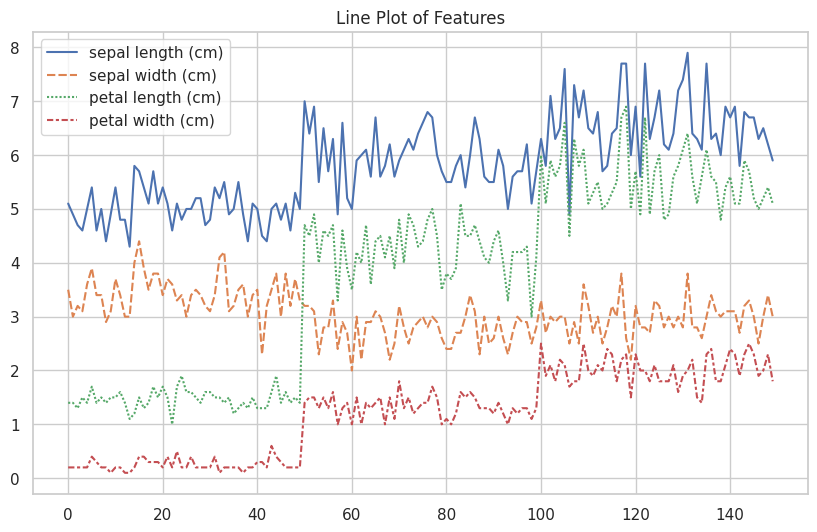

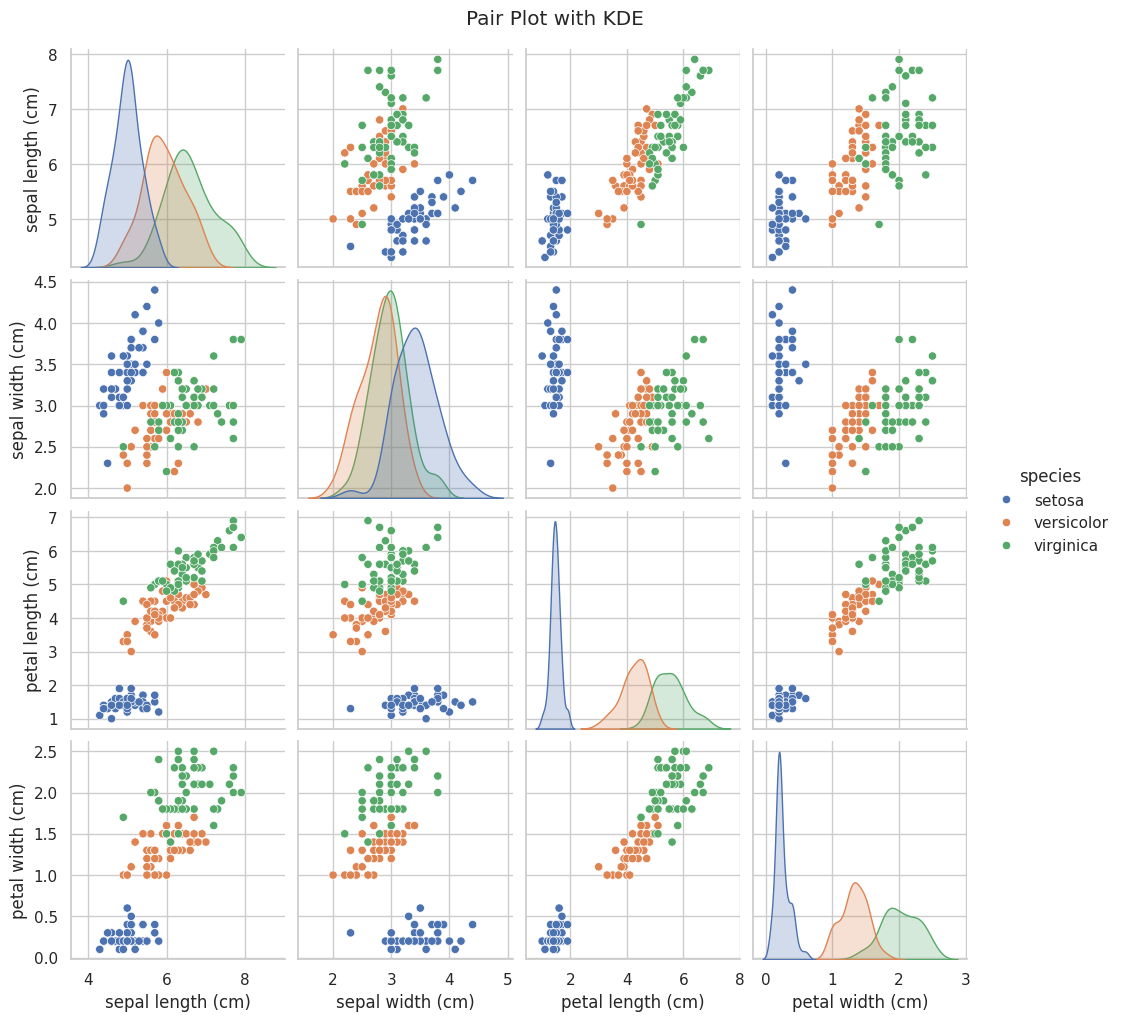


Variables ranked by correlation with 'petal length (cm)':


,petal length (cm)
petal width (cm),0.962865
sepal length (cm),0.871754
sepal width (cm),-0.428440


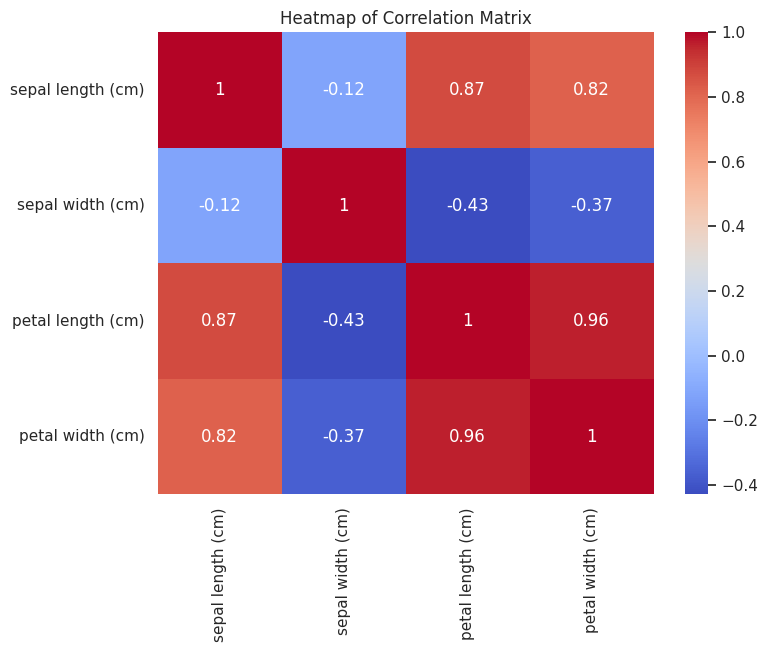

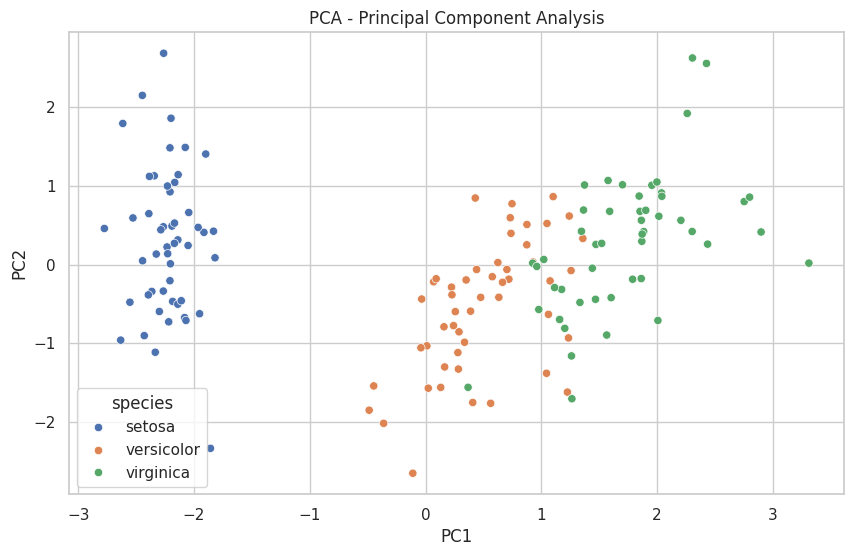


Explained Variance Ratio by Principal Components:
[0.72962445 0.22850762]

--- Summary of Analysis ---
1. Variables highly correlated with 'petal length (cm)':


,petal length (cm)
petal width (cm),0.962865
sepal length (cm),0.871754


2. PCA shows that most of the variance is captured by the first 2 components.
3. The species are well-separated in PCA plot, showing strong multivariate structure.
4. Heatmap and pairplots helped visualize strong feature correlations.

✅ Task Completed: Trends and ranks in multivariate data explored.


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab import files

# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Step 2: Load Data
# Option 1: Use built-in Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# Option 2: Upload your own file (uncomment below to use)
# uploaded = files.upload()
# df = pd.read_csv(next(iter(uploaded)))

print("First 5 rows of the dataset:")
display(df.head())

# Step 3: Data Cleaning
print("\nChecking for missing values:")
print(df.isnull().sum())

# Step 4: Descriptive Statistics
print("\nDescriptive statistics:")
display(df.describe(include='all'))

# Step 5: Correlation Matrix
print("\nCorrelation matrix (numeric features only):")
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
display(correlation_matrix)

# Step 6: Trend Analysis (Line Plot & Scatter Plot)
sns.lineplot(data=df.drop('species', axis=1))
plt.title("Line Plot of Features")
plt.show()

sns.pairplot(df, hue="species", diag_kind="kde")
plt.suptitle("Pair Plot with KDE", y=1.02)
plt.show()

# Step 7: Ranking Variables based on Correlation with Target (if applicable)
# For demonstration, we correlate numerical features with petal length
target_col = "petal length (cm)"
ranking = correlation_matrix[target_col].drop(target_col).sort_values(ascending=False)
print(f"\nVariables ranked by correlation with '{target_col}':")
display(ranking)

# Step 8: Visualize Correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Heatmap of Correlation Matrix")
plt.show()

# Step 9: Multivariate Analysis using PCA
features = df.select_dtypes(include=[np.number]).columns
x = df[features].values
x_scaled = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["species"] = df["species"]

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="species")
plt.title("PCA - Principal Component Analysis")
plt.show()

print("\nExplained Variance Ratio by Principal Components:")
print(pca.explained_variance_ratio_)

# Step 10: Summarize Findings
print("\n--- Summary of Analysis ---")
print(f"1. Variables highly correlated with '{target_col}':")
display(ranking.head(2))
print("2. PCA shows that most of the variance is captured by the first 2 components.")
print("3. The species are well-separated in PCA plot, showing strong multivariate structure.")
print("4. Heatmap and pairplots helped visualize strong feature correlations.")

print("\n✅ Task Completed: Trends and ranks in multivariate data explored.")
